In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler

import nltk
import spacy
import string
import evaluate
import transformers

from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, T5TokenizerFast

import loralib as lora

import warnings
warnings.filterwarnings("ignore")

In [2]:
class QA_Dataset(Dataset):
    '''
    Follow the question answering input format of UnifiedQA: https://arxiv.org/pdf/2005.00700.pdf
    '''
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.data = dataframe
        self.question = self.data['question']
        self.choices = self.data['choices']
        self.label = self.data['label']
        
    def __len__(self):
        return len(self.question)
    
    def __getitem__(self, idx):
        question = self.question[idx]
        choices = self.choices[idx]
        label = int(self.label[idx])
        answer = choices[label]
        
        # Append choices to question following style of UnifiedQA
        # question \n (A) c1 (B) c2 . . .       
        letters = ['(A)', '(B)', '(C)', '(D)', '(E)']
        question = question + ' \n'
        for i, c in enumerate(choices):
            question += f' {letters[i]} {c}'
        question_for_tok =  question
        answer_for_tok = answer
        question_tokenized = self.tokenizer(question_for_tok, max_length=self.q_len, padding="max_length",
                                            truncation=True, pad_to_max_length=True, add_special_tokens=True)
        answer_tokenized = self.tokenizer(answer_for_tok, max_length=self.t_len, padding="max_length", 
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True)
    
        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "decoder_input_ids": torch.tensor(answer_tokenized["input_ids"], dtype=torch.long),
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long),
            "question": question,
            "ref_answer": answer,
        }


class Trainer:
    def __init__(self, model, optimizer, tokenizer, train_loader, val_loader, use_lora=False, device='cuda'):
        self.model = model
        self.optimizer = optimizer
        self.tokenizer = tokenizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.use_lora = use_lora
        self.device = device
        self.bleu = evaluate.load("google_bleu")

    def train_epoch(self):
        self.model = self.model.to(self.device)
        self.model.train()
        if self.use_lora:
            lora.mark_only_lora_as_trainable(self.model)

        train_loss = 0
        train_batch_count = 0
        for batch in tqdm_notebook(self.train_loader, desc="Training batches"):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["decoder_input_ids"].to(self.device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(self.device)
    
            outputs = self.model(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 labels=labels,
                                 decoder_attention_mask=decoder_attention_mask)
    
            self.optimizer.zero_grad()
            outputs.loss.backward()
            self.optimizer.step()
            train_loss += outputs.loss.item()
            train_batch_count += 1

        return train_loss / train_batch_count

    def validate_epoch(self):
        self.model = self.model.to(self.device)
        self.model.eval()
        val_loss = 0
        val_batch_count = 0
        predicted_answers = []
        ref_answers = []
        correct_num = 0
        total_num = 0
        
        for batch in tqdm_notebook(self.val_loader, desc="Validation batches"):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["decoder_input_ids"].to(self.device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(self.device)
            
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     labels=labels,
                                     decoder_attention_mask=decoder_attention_mask)
                val_loss += outputs.loss.item()
                val_batch_count += 1
    
            # Store val outputs and metrics
            bs = outputs.logits.shape[0]
            for b_idx in range(bs):
                logits = outputs.logits[b_idx]
                tokens = torch.argmax(logits, dim=1)
                end_tok_idx = (tokens == 1).nonzero()
    
                if end_tok_idx.size(0) > 0:
                    end_tok_idx = end_tok_idx[0].item()
                    if end_tok_idx+1 < tokens.size(0):
                        tokens[end_tok_idx+1:] = 0
                
                predicted_answer = self.tokenizer.decode(tokens, skip_special_tokens=True)
                ref_answer = batch['ref_answer'][b_idx]
    
                predicted_answers.append(predicted_answer)
                ref_answers.append(ref_answer)
                if ref_answer in predicted_answer:
                    correct_num += 1
                total_num += 1
        
        # Finish calculating val metrics
        val_acc = correct_num / total_num
        bleu_score = self.bleu.compute(predictions=predicted_answers, references=ref_answers)['google_bleu']

        return {'val_loss': val_loss/val_batch_count, 'val_acc': val_acc, 'bleu_score': bleu_score}


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_acc = -float('inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.min_validation_acc + self.min_delta:
            self.min_validation_acc = validation_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def apply_lora(model, num_blocks=12, model_d=768, lora_r=16):
    # Apply LoRA to all attention matrices in the transformer block: q,k,v,o
    for i in range(num_blocks):
        model.encoder.block[i].layer[0].SelfAttention.q = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.encoder.block[i].layer[0].SelfAttention.k = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.encoder.block[i].layer[0].SelfAttention.v = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.encoder.block[i].layer[0].SelfAttention.o = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        
        model.decoder.block[i].layer[0].SelfAttention.q = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.decoder.block[i].layer[0].SelfAttention.k = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.decoder.block[i].layer[0].SelfAttention.v = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.decoder.block[i].layer[0].SelfAttention.o = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        
        model.decoder.block[i].layer[1].EncDecAttention.q = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.decoder.block[i].layer[1].EncDecAttention.k = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.decoder.block[i].layer[1].EncDecAttention.v = lora.Linear(model_d, model_d, r=lora_r, bias=False)
        model.decoder.block[i].layer[1].EncDecAttention.o = lora.Linear(model_d, model_d, r=lora_r, bias=False)

In [3]:
model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
use_lora = True
lora_r = 16
if use_lora:
    apply_lora(model, lora_r=lora_r)
    model.load_state_dict(torch.load('t5-base.pth'), strict=False)

tokenizer = T5TokenizerFast.from_pretrained("t5-base")
optimizer = optim.AdamW(model.parameters(), lr=3e-3, eps=1e-8, weight_decay=0.0) # For lora, use 3e-3, otherwise 1e-4 learning rate
q_len = 512   # Question Length
t_len = 64    # Target Length
train_batch_size = 16
val_batch_size = 8
device = 'cuda:0'
num_epochs = 20

In [5]:
# Loading the data
train_file = 'datasets/CommonsenseQA/commonsenseqa_mcq_train.json'
val_file = 'datasets/CommonsenseQA/commonsenseqa_mcq_val.json'
#train_file = 'datasets/MedQA/medqa_mcq_train.json'
#val_file = 'datasets/MedQA/medqa_mcq_val.json'
#train_file = 'datasets/ScienceQA/scienceqa_mcq_train.json'
#val_file = 'datasets/ScienceQA/scienceqa_mcq_val.json'

with open(train_file) as file:
    train_data = json.load(file)
    
with open(val_file) as file:
    val_data = json.load(file)

# Create Dataframes
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)

# Dataloader
train_dataset = QA_Dataset(tokenizer, train_data, q_len, t_len)
val_dataset = QA_Dataset(tokenizer, val_data, q_len, t_len)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

# Trainer
trainer = Trainer(model, optimizer, tokenizer, train_loader, val_loader, use_lora=use_lora, device=device)

In [6]:
# Training loop
loss_log = []
val_metrics_log = []
best_val_acc = -1.0
best_model_path = ''
early_stopping = EarlyStopper(patience=3, min_delta=1e-3)

for epoch in range(num_epochs):
    train_loss = trainer.train_epoch()
    val_metrics = trainer.validate_epoch()

    val_loss = val_metrics['val_loss']
    val_acc = val_metrics['val_acc']
    val_bleu = val_metrics['bleu_score']
    
    loss_log.append((train_loss, val_loss))
    val_metrics_log.append((val_acc, val_bleu))

    print('Saving model...')   
    checkpoint_path = f'results/medical_qa/t5_base_lora_epoch{epoch+1}.pth'
    if use_lora:
        torch.save(lora.lora_state_dict(model), checkpoint_path)
    else:
        torch.save(model.state_dict(), checkpoint_path)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = checkpoint_path
    
    print(f"{epoch+1}/{num_epochs} -> Train loss: {train_loss} \tValidation loss: {val_loss} " + \
          f"\tValidation Acc: {val_acc:.3f} \tValidation Bleu: {val_bleu:.3f}")

    if early_stopping.early_stop(val_acc):
        break

# Save best
if use_lora:
    torch.save(torch.load(best_model_path), 'results/medical_qa/t5_base_lora_best.pth')
else:
    torch.save(torch.load(best_model_path), 'results/medical_qa/t5_base_best.pth')

Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
1/20 -> Train loss: 0.2287654866328466 	Validation loss: 0.03546393089839872 	Validation Acc: 0.200 	Validation Bleu: 0.716


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
2/20 -> Train loss: 0.0426084136113735 	Validation loss: 0.03407091058134658 	Validation Acc: 0.209 	Validation Bleu: 0.731


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
3/20 -> Train loss: 0.04003823159651442 	Validation loss: 0.033636595655537255 	Validation Acc: 0.233 	Validation Bleu: 0.742


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
4/20 -> Train loss: 0.038395367513061315 	Validation loss: 0.033503252602879355 	Validation Acc: 0.227 	Validation Bleu: 0.734


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
5/20 -> Train loss: 0.03683501955712422 	Validation loss: 0.03318074474450927 	Validation Acc: 0.240 	Validation Bleu: 0.745


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
6/20 -> Train loss: 0.035859903984438495 	Validation loss: 0.03256500278066539 	Validation Acc: 0.233 	Validation Bleu: 0.747


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
7/20 -> Train loss: 0.03480905411381924 	Validation loss: 0.033918628820552015 	Validation Acc: 0.245 	Validation Bleu: 0.742


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
8/20 -> Train loss: 0.033529507510913784 	Validation loss: 0.034702646844791914 	Validation Acc: 0.252 	Validation Bleu: 0.745


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
9/20 -> Train loss: 0.03215353935956955 	Validation loss: 0.03559563044200903 	Validation Acc: 0.258 	Validation Bleu: 0.751


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
10/20 -> Train loss: 0.03206357528752351 	Validation loss: 0.035107905408308944 	Validation Acc: 0.242 	Validation Bleu: 0.741


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
11/20 -> Train loss: 0.030345334362946275 	Validation loss: 0.035565639477012294 	Validation Acc: 0.259 	Validation Bleu: 0.744


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
12/20 -> Train loss: 0.02828360285779558 	Validation loss: 0.036398643311464564 	Validation Acc: 0.235 	Validation Bleu: 0.745


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
13/20 -> Train loss: 0.027818774934594916 	Validation loss: 0.03761932106231743 	Validation Acc: 0.252 	Validation Bleu: 0.749


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
14/20 -> Train loss: 0.026738628337168526 	Validation loss: 0.03754595937148768 	Validation Acc: 0.269 	Validation Bleu: 0.756


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
15/20 -> Train loss: 0.02546433529858967 	Validation loss: 0.0381164884417312 	Validation Acc: 0.269 	Validation Bleu: 0.752


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
16/20 -> Train loss: 0.023910010002518373 	Validation loss: 0.04095499871193238 	Validation Acc: 0.262 	Validation Bleu: 0.747


Training batches:   0%|          | 0/637 [00:00<?, ?it/s]

Validation batches:   0%|          | 0/159 [00:00<?, ?it/s]

Saving model...
17/20 -> Train loss: 0.023642319614240195 	Validation loss: 0.040022428235355414 	Validation Acc: 0.243 	Validation Bleu: 0.741


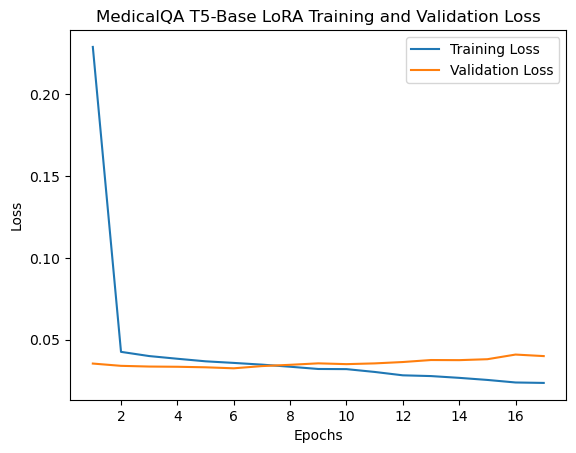

In [7]:
# Plot training and validation curves
train_loss = [x[0] for x in loss_log]
val_loss = [x[1] for x in loss_log]
epochs = range(1, len(loss_log)+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('MedicalQA T5-Base LoRA Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display and save the plot
plt.legend(loc='best')
plt.savefig("medicalqa_t5_base_lora_train_val_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

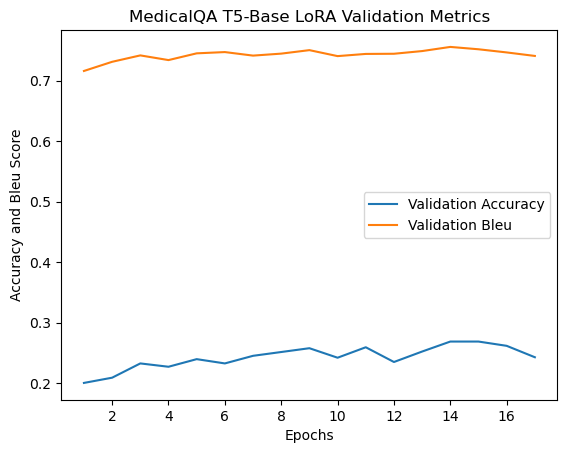

In [8]:
# Plot validation metrics
acc = [x[0] for x in val_metrics_log]
bleu = [x[1] for x in val_metrics_log]
epochs = range(1, len(loss_log)+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, acc, label='Validation Accuracy')
plt.plot(epochs, bleu, label='Validation Bleu')
 
# Add in a title and axes labels
plt.title('MedicalQA T5-Base LoRA Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Bleu Score')
 
# Display and save the plot
plt.legend(loc='best')
plt.savefig("medicalqa_t5_base_lora_val_metrics.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
# Qualitative examples
i = 1
data = val_dataset.__getitem__(i)
input_ids = data['input_ids'].to(device).unsqueeze(0)
attention_mask = data['attention_mask'].to(device).unsqueeze(0)

outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
predicted_answer = tokenizer.decode(outputs.flatten(), skip_special_tokens=True)

print(data['question'], '\n')
print('predicted_answer:', predicted_answer)
print('correct_answer:', data['ref_answer'])

What do people aim to do at work? 
 (A) complete job (B) learn from each other (C) kill animals (D) wear hats (E) talk to each other 

predicted_answer: complete job
correct_answer: complete job
